In [2]:
import librosa
import numpy as np
import pandas as pd
import h5py
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.model_selection import StratifiedShuffleSplit

import sys
sys.path.append('..')

%matplotlib inline

from laughter_classification.sspnet_data_sampler import SSPNetDataSampler

Using TensorFlow backend.


In [10]:
RATE = 16000 # samples in sec
DUR = 11 # file duration in seconds
LEN = RATE * DUR # samples in file (176000)
FRAME_SEC = 0.5 # seconds in frame
FRAME_SIZE = int(RATE * FRAME_SEC) # samples if frame (8000)
FRAME_STEP = int(FRAME_SIZE / 5) # samples between successive frames (1600)
NUM_CLASSES = 2 # laught or not

* Added `LibrosaExtractor` in `laughter_prediction.feature_extractors` to extract MFCC and FBANK features using librosa, using it in `SSPNetDataSampler`.


* Rewrote `SSPNetDataSampler` in `laughter_classification.sspnet_data_sampler` which creates dataset from vocalizationcorpus and returns DataFrame with overlapping frames described by features, label of class and filename.

In [11]:
# smplr = SSPNetDataSampler('../../data/vocalizationcorpus/')
# data = smplr.create_sampled_df(FRAME_SEC)
# data.to_csv('../../data/samples.csv', index=False)

data = pd.read_csv('../../data/samples.csv')

In [12]:
data.shape

(287175, 150)

In [13]:
frames_num = 105 # number of frames for each .wav file
vector_len = 148 # number of features describing each frame

In [14]:
data.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V140,V141,V142,V143,V144,V145,V146,V147,IS_LAUGHTER,SNAME
0,903.469993,22.110552,13.151943,46.213083,-17.533179,23.288871,-17.945700,4.478985,-16.021022,-8.827005,...,8.985123e+07,4.989764e+07,4.625960e+07,3.625273e+07,5.107908e+07,7.357580e+07,6.407850e+07,7.800024e+06,False,S1584
1,984.319736,21.231838,2.953489,44.678074,-19.402026,14.163532,-21.600310,0.101438,-18.760751,-7.042315,...,2.104042e+08,2.243163e+08,3.022200e+08,2.158124e+08,1.993383e+08,1.572147e+08,1.265192e+08,2.348908e+07,False,S1584
2,1022.190698,33.532349,-3.279695,38.394860,-25.989993,9.349846,-21.051692,-6.710757,-19.321560,-5.070256,...,2.286517e+08,2.385465e+08,3.099776e+08,2.240567e+08,2.065902e+08,1.629597e+08,1.324797e+08,2.509720e+07,False,S1584
3,1061.268787,30.639947,-4.961195,29.276434,-25.571131,8.788084,-21.397945,-6.496737,-16.397063,-1.047615,...,6.105167e+08,4.207161e+08,3.784505e+08,3.184893e+08,2.554543e+08,1.928747e+08,1.593636e+08,3.782155e+07,False,S1584
4,1074.259395,33.744219,-11.850305,20.757621,-25.812979,4.828652,-22.944275,-5.730192,-17.161470,1.973448,...,9.164058e+08,7.139229e+08,4.837591e+08,4.990330e+08,3.617077e+08,1.806479e+08,1.369564e+08,4.479941e+07,False,S1584


Let's see distribution of laugh frames number for files.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c7b1e50>]],
      dtype=object)

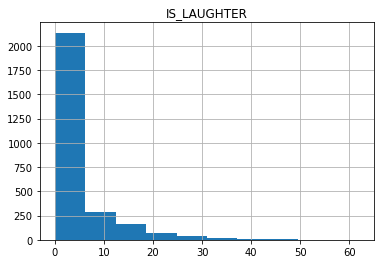

In [15]:
pivoted = data.pivot_table(index='SNAME', values='IS_LAUGHTER', aggfunc=np.sum)
pivoted.hist()

In [16]:
pivoted.head(2)

,IS_LAUGHTER
SNAME,
S0001,0.0
S0002,12.0


Dividing dataset into `train` and `test` subsets saving the distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d16d990>]],
      dtype=object)

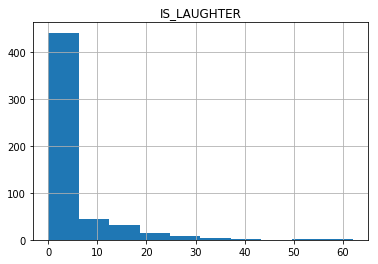

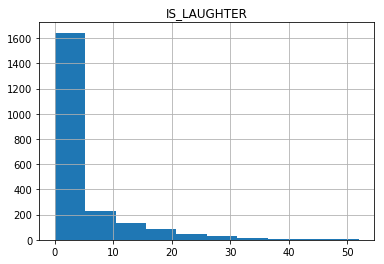

In [17]:
X = pivoted['IS_LAUGHTER'].index
y = pivoted['IS_LAUGHTER'].values // 21

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    
test = data[data['SNAME'].isin(X_test)]
train = data[data['SNAME'].isin(X_train)]

test.pivot_table(index='SNAME', values='IS_LAUGHTER', aggfunc=np.sum).hist()
train.pivot_table(index='SNAME', values='IS_LAUGHTER', aggfunc=np.sum).hist()

In [18]:
train = np.array(train.drop(columns='SNAME')).astype(float)
test = np.array(test.drop(columns='SNAME')).astype(float)

In [19]:
X_train, y_train = train[:, :-1].reshape(len(train) // frames_num, frames_num, vector_len), train[:, -1]
X_test, y_test = test[:, :-1].reshape(len(test) // frames_num, frames_num, vector_len), test[:, -1]

X shape:
* `number of .wav files`
* `number of frames in each file`
* `number of features describing each frame`

In [20]:
X_test.shape

(547, 105, 148)

In [21]:
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES).reshape(len(train) // frames_num, frames_num, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES).reshape(len(test) // frames_num, frames_num, NUM_CLASSES)

y shape:
* `number of .wav files`
* `number of frames in each file`
* `one-hot encoding for two classes`

In [22]:
y_test.shape

(547, 105, 2)

In [23]:
del data

Creating simple many-to-many RNN model followed by fully connected layer.

In [24]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(frames_num, vector_len)))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [25]:
model.fit(X_train, y_train,
          batch_size=10,
          epochs=10,
          verbose=1
         )

Epoch 1/10
2188/2188 [==============================] - 29s 13ms/step - loss: 0.4085 - acc: 0.8208
Epoch 2/10
2188/2188 [==============================] - 26s 12ms/step - loss: 0.1713 - acc: 0.9614
Epoch 3/10
2188/2188 [==============================] - 27s 12ms/step - loss: 0.1575 - acc: 0.9625
Epoch 4/10
2188/2188 [==============================] - 26s 12ms/step - loss: 0.1525 - acc: 0.9626
Epoch 5/10
2188/2188 [==============================] - 26s 12ms/step - loss: 0.1497 - acc: 0.9627
Epoch 6/10
2188/2188 [==============================] - 29s 13ms/step - loss: 0.1479 - acc: 0.9628
Epoch 7/10
2188/2188 [==============================] - 28s 13ms/step - loss: 0.1465 - acc: 0.9629
Epoch 8/10
2188/2188 [==============================] - 27s 12ms/step - loss: 0.1454 - acc: 0.9631
Epoch 9/10
2188/2188 [==============================] - 26s 12ms/step - loss: 0.1445 - acc: 0.9631
Epoch 10/10
2188/2188 [==============================] - 26s 12ms/step - loss: 0.1437 - acc: 0.9632


In [26]:
y_pred = model.predict(X_test)

In [27]:
y_test.shape

(547, 105, 2)

In [102]:
(y_test[:, :, 1] == (y_pred[:, :, 1] > 0.3)).sum() / (547. * 105) # accuracy

0.9606685818751632

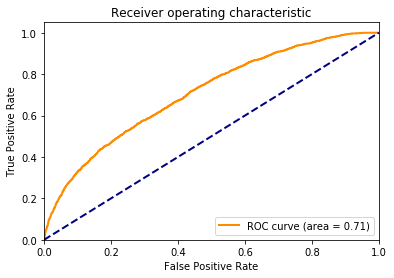

In [29]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test.reshape(-1, 2)[:, i], y_pred.reshape(-1, 2)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

class_id = 1

plt.figure()
lw = 2
plt.plot(fpr[class_id], tpr[class_id], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_id])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Let's display a couple samples with true intervals and predicted probability.

In [30]:
ind_to_display = np.argsort(y_test[:, :, 1].sum(axis=1))[-3:]

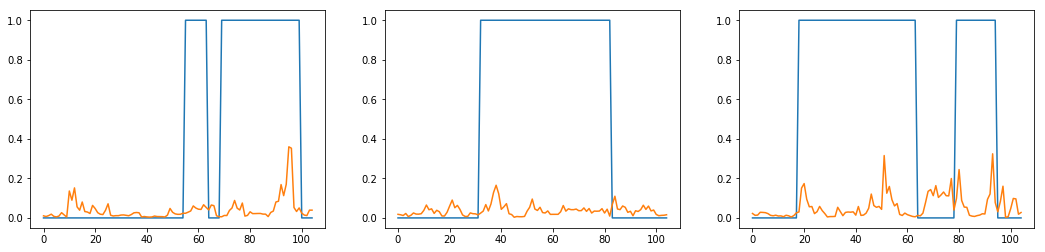

In [31]:
fig = plt.figure(figsize=(18, 4))

for i, ind in enumerate(ind_to_display):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(np.arange(frames_num), y_test[ind][:, 1], label='true')
    ax.plot(np.arange(frames_num), y_pred[ind][:, 1], label='pred')

Saving model. It will be used in `laughter_prediction.predictors` to detect laughter segments. To run `laughter_prediction.predictors` run the following command:


`python2 process_audio.py --wav_path=<wav_path>`


For example:
> `python2 process_audio.py --wav_path="../../data/vocalizationcorpus/data/S1582.wav"`

> \>`Target intervals`

> \>`[(0.7, 1.2), (1.2, 1.8), (3.6, 4.1)]`


In [41]:
model.save('../rnn-model.h5')

Model description:

In [87]:
model.evaluate(X_train, y_train) # log loss, accuracy

2188/2188 [==============================] - 3s 2ms/step


[0.1428294675169305, 0.9631844691428232]

In [86]:
model.evaluate(X_test, y_test)

547/547 [==============================] - 1s 2ms/step


[0.1430753255075685, 0.9648820434235568]

In [85]:
model.get_config()

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, 105, 148),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 1,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_2',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 100,
   'unroll': False,
   